# Index

+ [Compute precision-recall](#Load-ground-truths,-predictions,-plot-metrics)
+ [Metrics vs logo size](#metrics-vs-logo-size)
+ [Metrics by top brands](#metrics-by-brand)
+ [Visualize bounding box predictions](#visualize-bounding-box-predictions)

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

save_path = '/home/ubuntu/logohunter/notebooks'

###  Load ground truths, predictions, plot metrics

In [2]:
%cd '/home/ubuntu/logohunter/src/'
import metrics as mm

/home/ubuntu/logohunter/src


For each file, load ground truth masks and predictions

In [3]:
img_list, bbox_list_true = mm.read_txt_file('data_test.txt')
img_list_pred, bbox_list_pred = mm.read_txt_file('data_test_pred_logo.txt')

In [4]:
eps=0.01
(tp, fp, fn), match_dict = mm.count_tpfpfn_from_bboxes(bbox_list_true, bbox_list_pred, conf_thr=0.5, iou_thr=0.5)
prec, rec = prec, rec = (tp+eps)/(tp+fp+eps), (tp+eps)/(tp+fn+eps)
print('TP: {}, FP: {}, FN: {}'.format(tp, fp, fn))
print('precision: {:.3f}, recall: {:.3f}'.format(prec, rec))

TP: 4764, FP: 720, FN: 3253
precision: 0.869, recall: 0.594


In [5]:
list(map(len, [img_list_pred, img_list, bbox_list_true, bbox_list_pred]))

[2590, 2590, 2590, 2590]

Plot distribution of YOLO confidence for the predicted logos.

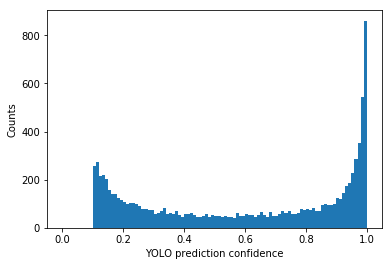

In [6]:
plt.hist([bb[-1] for r in bbox_list_pred for bb in r], bins=np.arange(0,1.01,0.01))
plt.gca().set(xlabel='YOLO prediction confidence', ylabel='Counts');

Compute precision-recall curves by changing prediction confidence threshold, and repeat for different IoU thresholds to establish a match.

In [7]:
iou_thr_list = np.arange(0.1,0.91,0.1)
prec, rec = mm.prec_recalls_from_bboxes(bbox_list_true, bbox_list_pred, 
                                        conf_thr_list = np.arange(0,1.01,0.01), iou_thr_list = iou_thr_list)

Mean Average Precision: IoU_min = 0.1, mAP=0.75
Mean Average Precision: IoU_min = 0.2, mAP=0.72
Mean Average Precision: IoU_min = 0.3, mAP=0.71
Mean Average Precision: IoU_min = 0.4, mAP=0.68
Mean Average Precision: IoU_min = 0.5, mAP=0.64
Mean Average Precision: IoU_min = 0.6, mAP=0.57
Mean Average Precision: IoU_min = 0.7, mAP=0.42
Mean Average Precision: IoU_min = 0.8, mAP=0.20
Mean Average Precision: IoU_min = 0.9, mAP=0.02


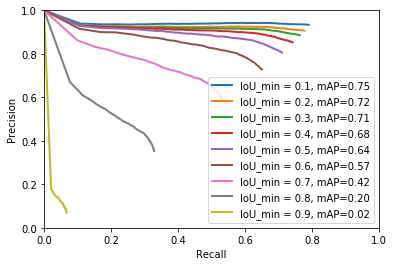

In [16]:
plt.gca().set(xlim=(0,1), ylim=(0,1), xlabel='Recall', ylabel='Precision')
for i in range(len(prec)):
    auc = np.trapz(prec[i], rec[i])
    lbl = 'IoU_min = {:.1f}, mAP={:.2f}'.format(iou_thr_list[i], auc)
    print('Mean Average Precision: {}'.format(lbl))
    plt.plot(rec[i], prec[i], label = lbl, lw=2)
#     plt.scatter(rec[i][::10], prec[i][::10]) # plot markers at confidence thresholds
plt.legend()
plt.savefig(os.path.join(save_path,'precision_recall.png'))

### metrics vs logo size

One expects a bigger logo is easier to recognize than a smaller logo. Let's quantify that

In [5]:
size_list = []
for i in range(len(img_list_pred)):
    bbox_list = bbox_list_true[i]
    for bbox in bbox_list:
        size_list.append([bbox[2]-bbox[0], bbox[3]-bbox[1]])

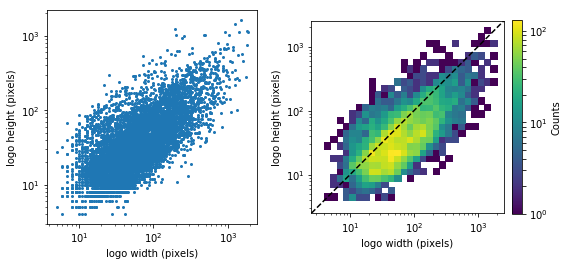

In [7]:
fig, axes = plt.subplots(1,2,figsize=(8,4))
axes[0].scatter(*zip(*size_list), s=4)

from matplotlib.colors import LogNorm
bins = 10**np.arange(0.4,3.5,0.1)

axes[1].plot((bins[0], bins[-1]), (bins[0], bins[-1]), 'k--')
counts, _, _ = np.histogram2d(*zip(*size_list), bins=bins)
im = axes[1].pcolor(bins, bins, counts.T, norm=LogNorm())
for ax in axes:
    ax.set(xscale='log', yscale='log', aspect=1, xlabel='logo width (pixels)', ylabel='logo height (pixels)')
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.colorbar(im, fraction=0.046, pad=0.04, label ='Counts');
fig.tight_layout()
plt.savefig(os.path.join(save_path,'logo_size_dist.png'))

In [8]:
size_tp = []
size_fp = []
size_fn = []
size_tp_pred = []
for i_img in match_dict.keys():
#     for i_true in match_dict[i_img].keys():
    for i_true in range(len(bbox_list_true[i_img])):
        bbox_true = bbox_list_true[i_img][i_true]
        if i_true in match_dict[i_img].keys():
            i_pred = match_dict[i_img][i_true]
            bbox_pred = bbox_list_pred[i_img][i_pred]
            size_tp.append([bbox_true[2]-bbox_true[0], bbox_true[3]-bbox_true[1]])
            size_tp_pred.append([bbox_pred[2]-bbox_pred[0], bbox_pred[3]-bbox_pred[1]])
        else:
            size_fn.append([bbox_true[2]-bbox_true[0], bbox_true[3]-bbox_true[1]])
    for i_pred in range(len(bbox_list_pred[i_img])):
        bbox_pred = bbox_list_pred[i_img][i_pred]
        if bbox_pred[-1]>0.5 and i_pred not in match_dict[i_img].values():
            size_fp.append([bbox_pred[2]-bbox_pred[0], bbox_pred[3]-bbox_pred[1]])
list(map(len, [size_tp, size_tp_pred, size_fn, size_fp]))  

[4764, 4764, 3253, 760]

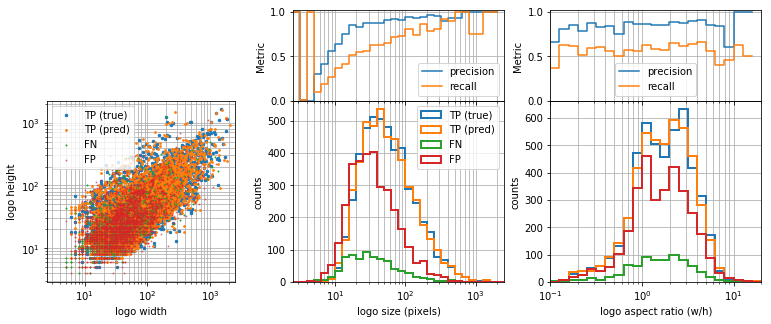

In [21]:
fig = plt.figure(figsize=(13, 5))
grid = plt.GridSpec(2, 3, hspace=0., wspace=0.22, height_ratios=(1,2))
axes = [ fig.add_subplot(grid[1:, i]) for i in range(3)]
taxes = [ fig.add_subplot(grid[0, i+1]) for i in range(2)]

bins_s, bins_ar = 10**np.arange(0.4,3.5,0.1), 10**np.arange(-1,1.4,0.1)
labels = ['TP (true)','TP (pred)','FN','FP']
for tax, topax in enumerate(taxes):
    bins = [bins_s, bins_ar][tax]
    counts_tp, _ = np.histogram([ [np.sqrt(np.prod(s)), s[0]/s[1]][tax] for s in size_tp], bins=bins)
    counts_fp, _ = np.histogram([ [np.sqrt(np.prod(s)), s[0]/s[1]][tax] for s in size_fp], bins=bins)
    counts_fn, _ = np.histogram([ [np.sqrt(np.prod(s)), s[0]/s[1]][tax] for s in size_fn], bins=bins)
    
    topax.step(bins[:-1], np.divide(counts_tp+0.01, counts_fp + counts_tp+0.01), label='precision')
    topax.step(bins[:-1], np.divide(counts_tp+0.01, counts_fn + counts_tp+0.01), label='recall')
    topax.set(xscale='log', ylim=[0.,1.02], ylabel='Metric', xlim=[bins[0],bins[-1]])
    topax.grid(which='both')
    topax.set_xticklabels([])
    topax.legend()
    iax=tax
    xlabel = 'logo {}'.format(['size (pixels)', 'aspect ratio (w/h)'][iax])
    axes[iax+1].set(xscale='log', xlabel=xlabel, ylabel='counts', xlim=[bins[0],bins[-1]])

for i in range(4):
    size = [size_tp, size_tp_pred, size_fp, size_fn][i]
    label = labels[i]
    
    axes[0].scatter(*zip(*size), s=[6,3,1,1][i], alpha=[1,1,1,.5][i], label=labels[i])
    axes[0].set(xscale='log', yscale='log', aspect=1, xlabel='logo width', ylabel='logo height', xlim=[bins_s[0],bins_s[-1]])
    axes[0].legend()

    axes[1].hist([ np.sqrt(np.prod(s)) for s in size], bins=bins_s, lw=2, histtype='step', label=label)
    axes[1].legend()
    
    axes[2].hist([ s[0]/s[1] for s in size], bins=bins_ar, lw=2, histtype='step', label=label)
    
for ax in axes:
    ax.set_axisbelow(True)
    ax.grid(which='both')

plt.savefig(os.path.join(save_path,'logo_size_metrics.png'), bbox_inches='tight')

### metrics by brand

In [14]:
img_list, bbox_list_true = mm.read_txt_file('data_all_test.txt')
img_list_pred, bbox_list_pred = mm.read_txt_file('data_test_pred_logo.txt')
with open('brands.txt') as f:
    brands = f.read().splitlines() 

In [15]:
n = len(bbox_list_true)
brand_dict = { i:{} for i in range(n)}
top_brands = { }
for i in range(n):
    for j in range(len(bbox_list_true[i])):
        brand_dict[i][j] = bbox_list_true[i][j][-1]
        if brand_dict[i][j] in top_brands:
            top_brands[brand_dict[i][j]] += 1
        else:
            top_brands[brand_dict[i][j]] = 1
top_brands = sorted( [[k,v] for k,v in top_brands.items()], key=lambda x: x[-1], reverse=True)

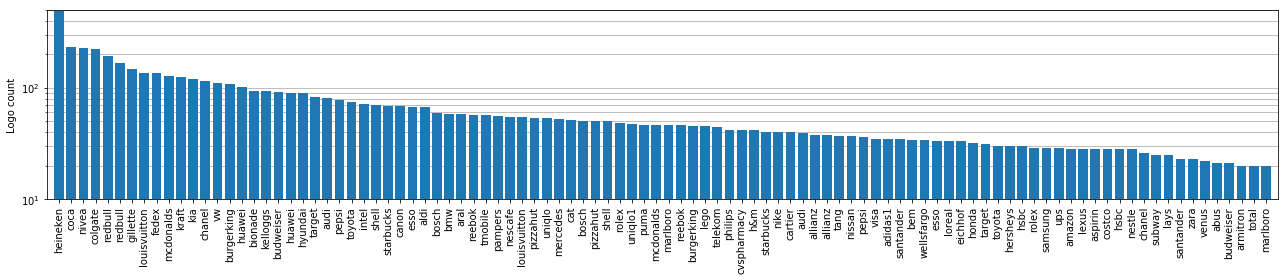

In [16]:
fig, ax = plt.subplots(1,1,figsize=(18,4))
n_plot = 100
top_labels = [brands[i].split('-')[0] for i in list(zip(*top_brands))[0][:n_plot]]
ax.bar(range(n_plot), list(zip(*top_brands))[1][:n_plot], tick_label = top_labels)
ax.set(xlim=(-1,n_plot), ylim = [10,500], yscale='log', ylabel='Logo count');
plt.xticks(rotation=90);
ax.set_axisbelow(True)
ax.grid(which='both', axis='y')

fig.tight_layout()
plt.savefig(os.path.join(save_path,'logo_brands_dist.png'))

In [17]:
bbox_brand_list = {}
for brand_id, count in top_brands:
    bbox_brand_list[brand_id] = []
    for i in range(n):
        bbox_brand_list[brand_id].append([])
        for j in range(len(bbox_list_true[i])):
            bbox = bbox_list_true[i][j]
            if bbox[-1] == brand_id:
                bbox_brand_list[brand_id][i].append(bbox)


In [18]:
tpfpfn_list = []
prec_rec_list = []
eps = 0.01
for brand_id, count in top_brands:
    (tp, fp, fn), match_dict = mm.count_tpfpfn_from_bboxes(bbox_brand_list[brand_id], bbox_list_pred, conf_thr=0.5, iou_thr=0.5)
    prec, rec = (tp+eps)/(tp+fp+eps), (tp+eps)/(tp+fn+eps)
    tpfpfn_list.append((tp, fp, fn))
    prec_rec_list.append((prec, rec))
    # print('TP: {}, FP: {}, FN: {}'.format(tp, fp, fn))
    # print('precision: {:.3f}, recall: {:.3f}'.format(prec, rec))


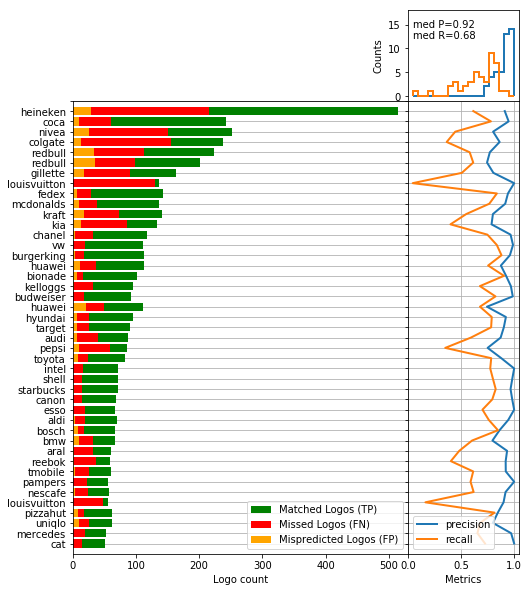

In [26]:
top_50 = [[brand, count] for brand, count in top_brands if count>50]

fig = plt.figure(figsize=(8, 10))
grid = plt.GridSpec(2, 2, hspace=0., wspace=0., width_ratios=(3,1), height_ratios=(1,5))
top_axes = [ fig.add_subplot(grid[0,i]) for i in range(1,2)]
axes = [ fig.add_subplot(grid[1,i]) for i in range(2)]
n_plot = len(top_50)

ax =axes[0]
tp, fp, fn = zip(*tpfpfn_list)
ax.barh(range(n_plot), tp[:n_plot][::-1], left = np.sum([fn, fp], axis=0)[:n_plot][::-1], color='g', label='Matched Logos (TP)')
ax.barh(range(n_plot), fn[:n_plot][::-1], left = fp[:n_plot][::-1], color='r', label='Missed Logos (FN)')
ax.barh(range(n_plot), fp[:n_plot][::-1], left = 0, color='orange', label='Mispredicted Logos (FP)')
ax.set(ylim=(-1,n_plot), xlim = [0,530], xlabel='Logo count', yticks=range(n_plot+1), yticklabels=top_labels[n_plot-1::-1])

ax =axes[1]
prec, rec = zip(*prec_rec_list)
ax.plot(prec[:n_plot][::-1], range(n_plot), lw=2, label = 'precision')
ax.plot(rec[:n_plot][::-1], range(n_plot), lw=2, label = 'recall')
ax.set(ylim=(-1,n_plot), xlabel='Metrics', yticks=range(n_plot+1), yticklabels=[]);
for iax in range(2):
    axes[iax].legend(loc=['lower right','lower left'][iax])
    axes[iax].set_axisbelow(True)
    axes[iax].grid(axis=['y', 'both'][iax])

ax = top_axes[0]
ax.hist(prec[:n_plot], bins=np.linspace(0,1,21), histtype='step', lw=2)
ax.hist(rec[:n_plot], bins=np.linspace(0,1,21), histtype='step', lw=2)
ax.text(0.,12,'med P={:.2f}\nmed R={:.2f}'.format(np.median(prec[:n_plot]), np.median(rec[:n_plot])))
# ax.text(0.2,10,'mean R={}'.format(np.mean(prec[:n_plot])))
ax.set(xlabel='Precision/Recall', ylabel='Counts', xticks=[], ylim=(-1,18), yticks=range(0,16,5));

plt.savefig(os.path.join(save_path,'logo_brands_metrics_vert.png'), bbox_inches='tight')

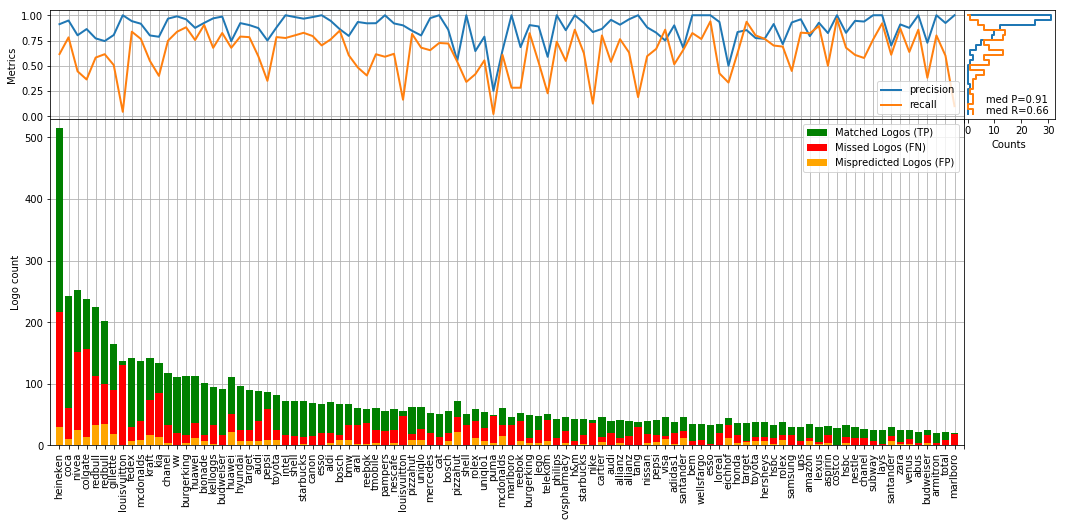

In [24]:
fig = plt.figure(figsize=(18, 8))
grid = plt.GridSpec(2, 2, hspace=0., height_ratios=(1,3), wspace=0, width_ratios=(10,1))
axes = [ fig.add_subplot(grid[i,0]) for i in range(2)]
n_plot = 100

ax = axes[1]
tp, fp, fn = zip(*tpfpfn_list)
ax.bar(range(n_plot), tp[:n_plot], bottom = np.sum([fn, fp], axis=0)[:n_plot], color='g', label='Matched Logos (TP)')
ax.bar(range(n_plot), fn[:n_plot], bottom = fp[:n_plot], color='r', label='Missed Logos (FN)')
ax.bar(range(n_plot), fp[:n_plot], bottom = 0, color='orange', label='Mispredicted Logos (FP)')
ax.set(xlim=(-1,n_plot), ylim = [0,530], ylabel='Logo count', xticks=range(n_plot+1), xticklabels=top_labels[:n_plot]);
plt.xticks(rotation=90);

ax = axes[0]
prec, rec = zip(*prec_rec_list)
ax.plot(prec[:n_plot], lw=2, label = 'precision')
ax.plot(rec[:n_plot], lw=2, label = 'recall')
ax.set(xlim=(-1,n_plot), ylabel='Metrics', xticks=range(n_plot+1), xticklabels=[]);
for iax in range(2):
    axes[iax].legend(loc=['lower right','upper right'][iax])
    axes[iax].set_axisbelow(True)
    axes[iax].grid(axis='both')

ax = fig.add_subplot(grid[0,1])
counts, bins = np.histogram(prec[:n_plot], bins=np.arange(10**-5,1.07,0.05))
ax.step(counts, bins[:-1], lw=2)
counts, bins = np.histogram(rec[:n_plot], bins=np.arange(10**-5,1.07,0.05))
ax.step(counts, bins[:-1], lw=2)
ax.text(7,0,'med P={:.2f}\nmed R={:.2f}'.format(np.median(prec[:n_plot]), np.median(rec[:n_plot])))
ax.set(xlabel='Counts', yticks=[], xticks=range(0,35,10))

plt.savefig(os.path.join(save_path,'logo_brands_metrics.png'), bbox_inches='tight')

Previous plot was for all brands with at least 20 examples.

Plot distribution of precision/recall for all elements with at least 5 examples


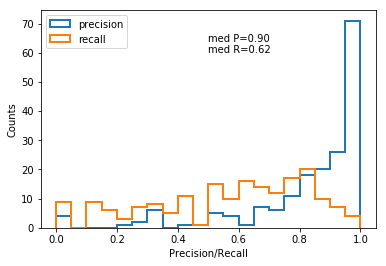

In [33]:
plt.hist(prec[:184], bins=np.linspace(0,1,21), histtype='step', lw=2)
plt.hist(rec[:184], bins=np.linspace(0,1,21), histtype='step', lw=2)
plt.text(0.5,60,'med P={:.2f}\nmed R={:.2f}'.format(np.median(prec[:184]), np.median(rec[:184])))
plt.gca().set(xlabel='Precision/Recall',ylabel='Counts')
plt.legend(['precision','recall'], loc=2);

### visualize bounding box predictions

In [10]:
bb1 = bbox_list_true[0][0]
bb2 = bbox_list_pred[0][0]
bb1, bb2

([92, 43, 116, 78, 0], [350, 140, 368, 148, 0, 0.9631204])

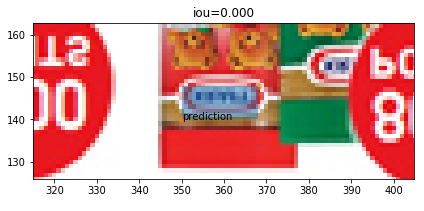

In [15]:
import matplotlib as mpl
plt.imshow(cv2.imread(img_list[0])[:,:,(2,1,0)])
for i, bb in enumerate([bb1, bb2]):
    plt.scatter([bb[0],bb[2]],[bb[1],bb[3]], alpha = 0.5)
    plt.gca().add_patch(mpl.patches.Rectangle((bb[0], bb[1]) ,bb[2]-bb[0], bb[3]-bb[1], alpha=0.5))
    plt.gca().annotate(['truth', 'prediction'][i], (bb[0],bb[1]))
plt.xlim(0.9*bb[0], 1.1*bb[2])
plt.ylim(0.9*bb[1], 1.1*bb[3])
plt.title('iou={:.3f}'.format(mm.iou_from_bboxes(bb1,bb2)))
plt.gcf().tight_layout();

True positives: 35 - False Positives: 15, False Negatives: 9
Precision: 0.700 - Recall:0.795


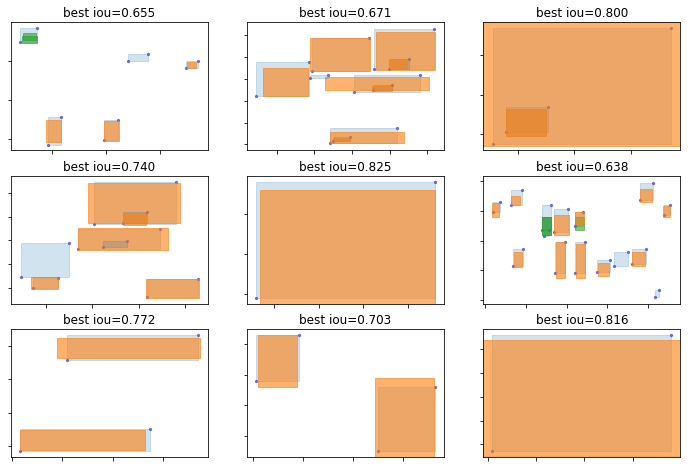

In [18]:
tp, fp, tpfp, fn = 0, 0, 0, 0
fig, axes = plt.subplots(3,3, figsize=(12,8))
match_dict = { i:{} for i in range(9)}
for i in range(9):#range(len(bbox_list_pred)):
    # axes[i//3, i%3].imshow(cv2.imread(img_list_pred[i])[:,:,(2,1,0)])
    for j, bb1 in enumerate(bbox_list_true[i]):
        axes[i//3, i%3].set(xticklabels='',yticklabels='')
        axes[i//3, i%3].scatter([bb1[0],bb1[2]],[bb1[1],bb1[3]], alpha = 0.5, c='b',s=5)
        axes[i//3, i%3].add_patch(mpl.patches.Rectangle((bb1[0], bb1[1]), 
            bb1[2]-bb1[0], bb1[3]-bb1[1], alpha=0.2, color=plt.get_cmap('tab10')(0)))
        for k, bb2 in enumerate(bbox_list_pred[i]):            
            if j in match_dict[i]:
                continue
            iou = mm.iou_from_bboxes(bb1, bb2)
            if iou == 0:
                continue
            if iou > 0.5:
                tp += 1
                match_dict[i][j] = k
                axes[i//3, i%3].add_patch(mpl.patches.Rectangle((bb2[0], bb2[1]), 
                  bb2[2]-bb2[0], bb2[3]-bb2[1], alpha=0.6, color=plt.get_cmap('tab10')(1)))
                axes[i//3, i%3].set(title='best iou={:.3f}'.format(mm.iou_from_bboxes(bb1,bb2)))
            elif iou > 0.1:
                fp += 1
                axes[i//3, i%3].add_patch(mpl.patches.Rectangle((bb2[0], bb2[1]), 
                  bb2[2]-bb2[0], bb2[3]-bb2[1], alpha=0.6, color=plt.get_cmap('tab10')(2)))
                axes[i//3, i%3].set(title='best iou={:.3f}'.format(mm.iou_from_bboxes(bb1,bb2)))
            else:
                fp += 1
    fn += len(bbox_list_true[i]) - len(match_dict[i])
print('True positives: {} - False Positives: {}, False Negatives: {}'.format(tp, fp, fn))
print('Precision: {:.3f} - Recall:{:.3f}'.format(tp/(tp+fp), tp/(tp+fn)))

True positives: 35 - False Positives: 15, False Negatives: 9
Precision: 0.700 - Recall:0.795


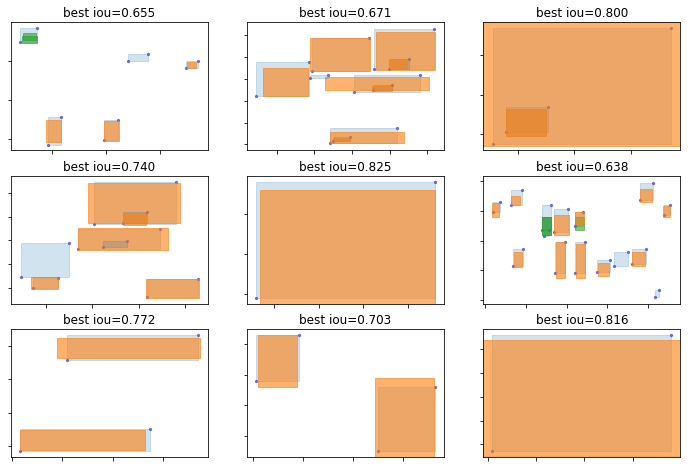

In [19]:
tp, fp, fn = 0, 0, 0
fig, axes = plt.subplots(3,3, figsize=(12,8))
match_dict = { i:{} for i in range(9)}
for i in range(9):#range(len(bbox_list_pred)):
    # axes[i//3, i%3].imshow(cv2.imread(img_list_pred[i])[:,:,(2,1,0)])
    for j, bb1 in enumerate(bbox_list_true[i]):
        axes[i//3, i%3].set(xticklabels='',yticklabels='')
        axes[i//3, i%3].scatter([bb1[0],bb1[2]],[bb1[1],bb1[3]], alpha = 0.5, c='b',s=5)
        axes[i//3, i%3].add_patch(mpl.patches.Rectangle((bb1[0], bb1[1]), 
            bb1[2]-bb1[0], bb1[3]-bb1[1], alpha=0.2, color=plt.get_cmap('tab10')(0)))
        for k, bb2 in enumerate(bbox_list_pred[i]):            
            if j in match_dict[i]:
                continue
            iou = mm.iou_from_bboxes(bb1, bb2)
            if iou == 0:
                continue
            if iou > 0.5:
                tp += 1
                match_dict[i][j] = k
                axes[i//3, i%3].add_patch(mpl.patches.Rectangle((bb2[0], bb2[1]), 
                  bb2[2]-bb2[0], bb2[3]-bb2[1], alpha=0.6, color=plt.get_cmap('tab10')(1)))
                axes[i//3, i%3].set(title='best iou={:.3f}'.format(mm.iou_from_bboxes(bb1,bb2)))
            elif iou > 0.1:
                fp += 1
                axes[i//3, i%3].add_patch(mpl.patches.Rectangle((bb2[0], bb2[1]), 
                  bb2[2]-bb2[0], bb2[3]-bb2[1], alpha=0.6, color=plt.get_cmap('tab10')(2)))
                axes[i//3, i%3].set(title='best iou={:.3f}'.format(mm.iou_from_bboxes(bb1,bb2)))
            else:
                fp += 1
    fn += len(bbox_list_true[i]) - len(match_dict[i])
print('True positives: {} - False Positives: {}, False Negatives: {}'.format(tp, fp, fn))
print('Precision: {:.3f} - Recall:{:.3f}'.format(tp/(tp+fp), tp/(tp+fn)))

Blue: True --- Yellow: predictions with IoU >= 0.5, Green: Predictions with IoU > 0.1

The dictionary holds the mapping between truth and predicted.    
For _each image index_, I have a mapping between **true boxes** and **matching predicted boxes**

To get the false negatives, pick the number of true boxes minus the number of matches

In [20]:
[(k, v, len(v)) for k,v in match_dict.items()]

[(0, {0: 4, 1: 2, 3: 0}, 3),
 (1, {0: 2, 1: 1, 2: 5, 3: 7, 4: 3, 5: 8, 6: 0, 7: 6}, 8),
 (2, {0: 1, 1: 0}, 2),
 (3, {0: 0, 1: 3, 2: 2, 3: 4, 4: 1}, 5),
 (4, {0: 0}, 1),
 (5,
  {0: 0, 1: 9, 2: 1, 3: 12, 4: 2, 7: 18, 8: 14, 9: 10, 11: 11, 12: 6, 13: 5},
  11),
 (6, {0: 0, 1: 1}, 2),
 (7, {0: 0, 1: 2}, 2),
 (8, {0: 0}, 1)]

If there are multiple predictions overlapping on the same ground truth, the previous algorithm picked the highest confidence. What happens if we pick the highest IoU?

True positives: 35 - False Positives: 15, False Negatives: 9
Precision: 0.700 - Recall:0.795


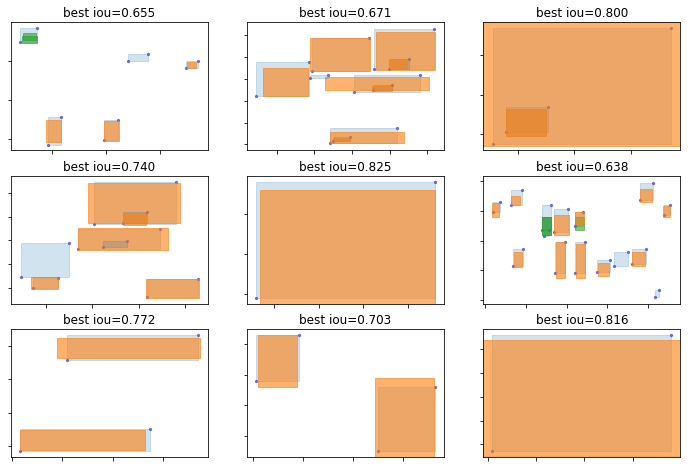

In [21]:
tp, fp, fn = 0, 0, 0
fig, axes = plt.subplots(3,3, figsize=(12,8))
match_dict = { i:{} for i in range(9)}
for i in range(9):#range(len(bbox_list_pred)):
    # axes[i//3, i%3].imshow(cv2.imread(img_list_pred[i])[:,:,(2,1,0)])
    for j, bb1 in enumerate(bbox_list_true[i]):
        axes[i//3, i%3].set(xticklabels='',yticklabels='')
        axes[i//3, i%3].scatter([bb1[0],bb1[2]],[bb1[1],bb1[3]], alpha = 0.5, c='b',s=5)
        axes[i//3, i%3].add_patch(mpl.patches.Rectangle((bb1[0], bb1[1]), 
            bb1[2]-bb1[0], bb1[3]-bb1[1], alpha=0.2, color=plt.get_cmap('tab10')(0)))
        for k, bb2 in enumerate(bbox_list_pred[i]):            
            
            iou = mm.iou_from_bboxes(bb1, bb2)
            if j in match_dict[i] and match_dict[i][j][-1] > iou:
                # skip if already found other object with larger IoU
                continue
            if iou == 0:
                continue
            if iou > 0.5:
                tp += 1
                match_dict[i][j] = (k,iou)
                axes[i//3, i%3].add_patch(mpl.patches.Rectangle((bb2[0], bb2[1]), 
                  bb2[2]-bb2[0], bb2[3]-bb2[1], alpha=0.6, color=plt.get_cmap('tab10')(1)))
                axes[i//3, i%3].set(title='best iou={:.3f}'.format(mm.iou_from_bboxes(bb1,bb2)))
            elif iou > 0.1:
                fp += 1
                axes[i//3, i%3].add_patch(mpl.patches.Rectangle((bb2[0], bb2[1]), 
                  bb2[2]-bb2[0], bb2[3]-bb2[1], alpha=0.6, color=plt.get_cmap('tab10')(2)))
                axes[i//3, i%3].set(title='best iou={:.3f}'.format(mm.iou_from_bboxes(bb1,bb2)))
            else:
                fp += 1
    fn += len(bbox_list_true[i]) - len(match_dict[i])
print('True positives: {} - False Positives: {}, False Negatives: {}'.format(tp, fp, fn))
print('Precision: {:.3f} - Recall:{:.3f}'.format(tp/(tp+fp), tp/(tp+fn)))

No difference here because no occurence of overlapping logos